# EDA | Text Prepocessing | Modelling | Embedding

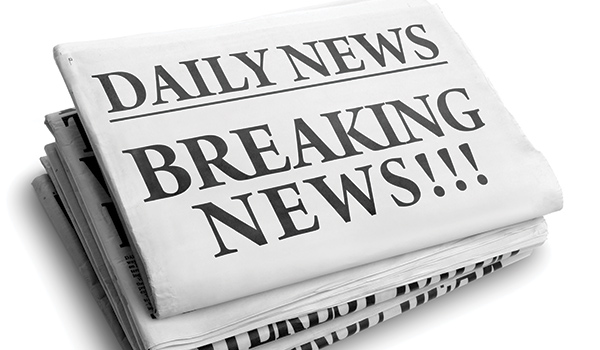

**We come across different type of news, some news can be bullshit, some news can be fake, some news are shown to express hate, and some news are published to make fun of others. Given the news content, we as humans are able to classify that article into different categories but can computers do it? Let's answer that question in this notebook.**

**We first explore the data in hand using Bokeh, and then draw certain conclusions from that. Then we will perform some text preprocessing using TF-IDF, once the data is preprocessed we apply Random Forest for modelling. During this, we will reliase the drawback of TF-IDF, which will take us to using Embeddings using TensorFlow.**

**Don't be overwhelmed by these steps, I am there to explain each step along the way.**

**Some of the methods used in this notebook has been inspired by Ruchi Bhatia's notebook**

**Do upvote the notebook if you liked it!**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly 
import plotly.express as px
import seaborn as sns
from math import pi

from IPython.core.display import HTML
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [ ]:
df = pd.read_csv('/kaggle/input/source-based-news-classification/news_articles.csv')
df.head()

In [ ]:
print("Number of rows present in the dataset are: ", df.shape[0])
print("Number of columns present in the dataset are: ", df.shape[1])

In [ ]:
df['type'].unique()

**These are the 8 different types of articles:** 
* bs (i.e. bullshit)

* junksci(i.e. junk science)

* hate

* fake

* conspiracy

* bias 

* satire 

* state


# Null Values

In [ ]:
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+0.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 0.5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()
msv_1(df, thresh = 5, color=sns.color_palette('Reds',15))

**There are close to 2.5% values which are missing in the columns 'text_without_stopwords' and 'text' and close to 0.5% missing values in columns like 'title_without_stop_words', 'language' etc. We will be dropping these null values.**

In [ ]:
df_orig = df.copy()
df.dropna(inplace = True)

In [ ]:
msv_1(df, thresh = 2, color=sns.color_palette('Reds',15))

**All the null values have been removed**

# Unigrams and Bigrams

In [ ]:
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.io import curdoc

In [ ]:
output_notebook()

In [ ]:
def get_top_n_words(corpus, n = None):
    """
    A function that returns the top 'n' unigrams used in the corpus
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus) ## Shape: (2045, 46774) -> There are 2045 sentences and 46774 words
    sum_words = bag_of_words.sum(axis=0) ## Shape: (1, 46774) -> Count of occurance of each word
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] ## vec.vocabulary_.items returns the dictionary with (word, index)
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return freq_sorted[:n]

def get_top_n_bigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

In [ ]:
top_unigram = get_top_n_words(df['text_without_stopwords'], 20)
words = [i[0] for i in top_unigram]
count = [i[1] for i in top_unigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#6baed6'] * 20))

p = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Unigrams", tools = "hover", tooltips = "@Word: @counts")
p.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
curdoc().theme = 'dark_minimal'
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.title.align = 'center'
p.xaxis.major_label_orientation = "vertical"
show(p)

In [ ]:
top_bigram = get_top_n_bigram(df['text_without_stopwords'], 20)
words = [i[0] for i in top_bigram]
count = [i[1] for i in top_bigram]
source = ColumnDataSource(data = dict(Word = words, counts = count, color = ['#a1dab4'] * 20))

p1 = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Bigrams", tools = "hover", tooltips = "@Word: @counts")
p1.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
# curdoc().theme = 'dark_minimal'
p1.xgrid.grid_line_color = None
p1.title.align = 'center'
p1.y_range.start = 0
p1.xaxis.major_label_orientation = "vertical"
show(p1)

**From the above unigrams and bigrams, the top words are "Hillary Clinton", "Donald Trump", "United States" and "election day" etc which suggests that this dataset was captured around the election days.**

In [ ]:
wc = WordCloud(background_color="black", max_words=100,
               max_font_size=256,
               random_state=42, width=1000, height=1000)
wc.generate(' '.join(df['text_without_stopwords']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
different_types = df['type'].value_counts().keys().to_list()
count = df['type'].value_counts().values
count1 = count / sum(count) * 100
angle = count / sum(count) * 2 * pi

source = ColumnDataSource(data = dict(types = different_types, count = count, color = ['skyblue', 'salmon', 'turquoise', 'cyan', 'red', 'lightseagreen', 'teal', 'mediumaquamarine'], angle = angle, percentage = count1))

p3 = figure(plot_height = 400, plot_width = 400, title="Proportion of Article Types",
           tools = "hover", tooltips = "@types: @percentage", x_range=(-1.0, 1.0))  ## Pie chart for different types

p3.wedge(x = 0, y = 1, radius = 0.8,
        start_angle = cumsum('angle', include_zero=True), end_angle = cumsum('angle'),
        line_color = "white", fill_color = 'color', legend_field = 'types', source = source)
p3.title.align = 'center'
p3.legend.location = "top_right"

p3.legend.label_text_font_size = '5pt'

show(p3)

# Different Types

In [ ]:
def top_bigrams_type(type_name, color_hex):
    """
    A function that plots the bar graph representing the top unigrams for 'type_name'
    """
    df_type = df[df['type'] == type_name]
    top = get_top_n_bigram(df_type['text_without_stopwords'], 20)
    words = [i[0] for i in top]
    count = [i[1] for i in top]
    source = ColumnDataSource(data = dict(Word = words, counts = count, color = [color_hex] * 20))

    p = figure(x_range = words, plot_height = 400, plot_width = 800, title = "Top Bigrams for " + type_name, tools = "hover", tooltips = "@Word: @counts")
    p.vbar(x = 'Word', top = 'counts', width = 0.8, source = source, color = 'color')
    curdoc().theme = 'dark_minimal'
    p.xgrid.grid_line_color = None
    p.title.align = 'center'
    p.y_range.start = 0
    p.xaxis.major_label_orientation = "vertical"
    show(p)

## Bias

In [ ]:
top_bigrams_type('bias', '#6baed6')

## Fake

In [ ]:
top_bigrams_type('fake', '#32a852')

## State

In [ ]:
top_bigrams_type('state', '#a83257')

## Hate

In [ ]:
top_bigrams_type('hate', '#9aa832')

**For the 'hate' type, the top bigrams are quite obvious beacuse during the elections, all would spread hate against the leader that they don't support. Some might be the supporters of Hillary Clinton, and some mighe be the supporters of Donald Trump.**

## bs

In [ ]:
top_bigrams_type('bs', '#11d9bb')

# Languages

In [ ]:
different_languages = df['language'].value_counts().keys().to_list()
count = df['language'].value_counts().values
count1 = count / sum(count) * 100
angle = count / sum(count) * 2 * pi

source = ColumnDataSource(data = dict(types = different_languages, count = count, color = ['skyblue', 'salmon', 'turquoise', 'red', 'lightseagreen'], angle = angle, percentage = count1))

p4 = figure(plot_height = 400, plot_width = 400, title = "Proportion of Article Languages",
           tools = "hover", tooltips = "@types: @percentage", x_range = (-1.0, 1.0))  ## Pie chart for different article languages

p4.wedge(x = 0, y = 1, radius = 0.8,
        start_angle = cumsum('angle', include_zero = True), end_angle = cumsum('angle'),
        line_color = "white", fill_color = 'color', legend_field = 'types', source = source)
p4.title.align = 'center'

p4.legend.location = "top_right"

p4.legend.label_text_font_size = '5pt'

show(p4)

# Label

In [ ]:
different_labels = df['label'].value_counts().keys().to_list()
count = df['label'].value_counts().values
count1 = count / sum(count) * 100
angle = count / sum(count) * 2 * pi

source = ColumnDataSource(data = dict(types = different_labels, count = count, color = ['skyblue', 'salmon'], angle = angle, percentage = count1))

p5 = figure(plot_height = 400, plot_width = 400, title = "Proportion of Real and Fake News",
           tools = "hover", tooltips = "@types: @percentage", x_range = (-1.0, 1.0))  ## Pie chart for different labels

p5.wedge(x = 0, y = 1, radius = 0.8,
        start_angle = cumsum('angle', include_zero = True), end_angle = cumsum('angle'),
        line_color = "white", fill_color = 'color', legend_field = 'types', source = source)
p5.title.align = 'center'

p5.legend.location = "top_right"

p5.legend.label_text_font_size = '5pt'

show(p5)

# Images

In [ ]:
df['hasImage'].value_counts()

**Using HTML to view the images given in form of image url**

In [ ]:
def convert(path):
    return '<img src="'+ path + '" width="80">'

In [ ]:
df_sources = df[['site_url','label','main_img_url', 'title_without_stopwords']]
df_r = df_sources.loc[df['label']== 'Real'].iloc[6 : 10,:]
df_f = df_sources.loc[df['label']== 'Fake'].head(6)

In [ ]:
HTML(df_r.to_html(escape = False, formatters = dict(main_img_url = convert)))

In [ ]:
HTML(df_f.to_html(escape = False, formatters = dict(main_img_url = convert)))

**Most of the fake news are being given by the 21stcenturywire.com. Let's check which are the sites that deliver fake news**

In [ ]:
print(f"Sites printing Fake news are: {r_}{df[df['label'] == 'Fake']['site_url'].unique()}")

**Getting the websites that publish fake news is fine but there might be sites where only 1 or 2 news were fake, let's take into the count consideration as well.**

In [ ]:
df[df['label'] == 'Fake']['site_url'].value_counts().head(5)

In [ ]:
df[df['label'] == 'Fake']['site_url'].value_counts().tail(5)

In [ ]:
sites = df[df['label'] == 'Fake']['site_url'].value_counts().head(10).index.tolist()
count = df[df['label'] == 'Fake']['site_url'].value_counts().head(10).values.tolist()
source = ColumnDataSource(data = dict(sites = sites, counts = count, color = ['#11d9bb'] * 10))

p6 = figure(x_range = sites, plot_height = 400, plot_width = 1200, title = "Count of Fake Stories Published by Sites", tools = "hover", tooltips = "@sites: @counts")
p6.vbar(x = 'sites', top = 'counts', width = 0.8, source = source, color = 'color')
curdoc().theme = 'dark_minimal'
p6.xgrid.grid_line_color = None
p6.title.align = 'center'
p6.y_range.start = 0

show(p6)

In [ ]:
print(f"Sites printing Real news are: {g_}{df[df['label'] == 'Real']['site_url'].unique()}")

In [ ]:
sites = df[df['label'] == 'Real']['site_url'].value_counts().head(10).index.tolist()
count = df[df['label'] == 'Real']['site_url'].value_counts().head(10).values.tolist()
source = ColumnDataSource(data = dict(sites = sites, counts = count, color = ['#6baed6'] * 10))

p7 = figure(x_range = sites, plot_height = 400, plot_width = 1200, title = "Count of Real Stories Published by Sites ", tools = "hover", tooltips = "@sites: @counts")
p7.vbar(x = 'sites', top = 'counts', width = 0.8, source = source, color = 'color')
curdoc().theme = 'dark_minimal'
p7.xgrid.grid_line_color = None
p7.title.align = 'center'
p7.y_range.start = 0

show(p7)

**Let's also check if there exists websites that publish both real and fake news**

In [ ]:
real = set(df[df['label'] == 'Real']['site_url'].unique())
fake = set(df[df['label'] == 'Fake']['site_url'].unique())
print(f"Websites publishing both real & fake news are {y_}{real & fake}")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() ## Converting the type column from object datatype to numerical datatype
df['type'] = le.fit_transform(df['type'])
df.head()

In [ ]:
le.classes_

In [ ]:
le.transform(['bias', 'bs', 'conspiracy', 'fake', 'hate', 'junksci', 'satire' , 'state'])

In [ ]:
mapping = {}
for i in le.classes_:
    mapping[i] = le.transform([i])[0]
print(mapping)

**Above is the mapping of the LabelEncoder, that is LabelEncoder has labeled bias as 0, bs as 1, and conspiracy as 2 etc**

In [ ]:
fig = px.sunburst(df, path=['label', 'type'])
fig.show()

**From the above plot, we can observe that all of the fake news was published for the type 1, 2, 6, 5, 3 i.e for bs, conspiracy, fake, junksci and satire. Whereas all the real news was publised for the type: 0, 4 and 7 i.e for bias, hate and state.**

# Sites that Publish Different Types of Stories

In [ ]:
def sites_type(df):
    types = df['type'].unique()
    for type in types:
        df_type = df[df['type'] == type]
        type = le.inverse_transform([type])
        print(f"{r_}The unique sites publishing article of type {type[0]} are: {g_}{df_type['site_url'].unique()}")
        print()

In [ ]:
sites_type(df)

**Our main aim is to predict the article type, and from the above output we can observe that the website url can also play a major role in the final prediction along with the text. But before moving forward, let's remove '.com' from the main urls.**

In [ ]:
urls = []
for url in df['site_url']:
    urls.append(url.split('.')[0])
df['site_url'] = urls

# Modelling

**In the dataset, the values are ordered. For example: all the site urls are ordered alphabetically, therefore we need to reshuffle the values.**

In [ ]:
df = df.sample(frac = 1)

In [ ]:
features = df[['site_url', 'text_without_stopwords']]
features.head(5)

**Let's combine both of them together to form a new column, url_text**

In [ ]:
features['url_text'] = features["site_url"].astype(str) + " " + features["text_without_stopwords"]
features.drop(['site_url', 'text_without_stopwords'], axis = 1, inplace = True)

In [ ]:
features.head()

In [ ]:
X = features
y = df['type']

In [ ]:
y = y.tolist()

# Using TF-IDF

**TF-IDF stands for term frequency-inverse document frequency**, and the tf-idf weight is often used in information retrieval and text mining. This weight is used to evaluate how important a word is to a document in a collection or corpus. 

The problem with including just the count of words is that certain words like **“the,” “and,” “is,” may be used a lot so they might be considered as “important” instead of the words that are actually important**, that’s where ‘idf’ comes into the picture. 

The importance increases proportionally to the number of times a word appears in the document but is balanced by the frequency of the word in the corpus.

Typically, the tf-idf weight is composed of two terms:
**Term Frequency (TF)**, aka. The number of times a word appears in a document, divided by the total number of words in that document;

**Inverse Document Frequency (IDF)**, computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

tfidf_vectorizer = TfidfVectorizer(use_idf = True, stop_words = 'english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['url_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['url_text'])

# We build our corpus only based on the train data because certain new words might occur in the test data
# that might occur in real life too. This ensures that our model can be generalized.

In [ ]:
X_train_tfidf.shape

In [ ]:
X_test_tfidf.shape

In [ ]:
tfidf_train = pd.DataFrame(X_train_tfidf.A, columns = tfidf_vectorizer.get_feature_names())

In [ ]:
tfidf_train.head()

**Above is the representation of the tf-idf matrix. The first represents the 'first url_text' and corresponding colum values represent the value of that column for 1st document. One point to note here is the presence of a very large number of zeros. We will be dealing with that in the next section**

In [ ]:
rfc = RandomForestClassifier(n_estimators=100,random_state=0)
rfc.fit(tfidf_train, y_train)
y_pred = rfc.predict(X_test_tfidf)
RFscore = metrics.accuracy_score(y_test, y_pred)
print("The accuracy is : ", RFscore)

In [ ]:
print("The Weighted F1 score is: ", metrics.f1_score(y_test, y_pred, average = 'weighted'))

# Embedding

**By applying the tf-idf method we used above, we observed that we get a lot of zeros for sentence representation, i.e we got a sparse matrix. Sparse Matrix is not a true representation for the corpus, and it doesn't take into account the similarity of the words. That is where Embeddings come to our rescue.**

A word embedding is a class of approaches for r**epresenting words and documents using a dense vector representation.**

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, **words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.**

The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

The position of a word in the learned vector space is referred to as its embedding.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

* We will set the maximum number of words allowed to be 100.

* In the test dataset, there can be words that are Out of Vocabulary(OOV), we will encode those words as OOV

* Embedding Dimension has been set to 32

* A lot of sentences might be very long, we will keep the maximum length to be 120.

* You might be wondering that all the sentences are not neccessarry to be of the same length, in order to tackle that we will use the concept of padding i.e to add zeros before or after the sentence to keep the length uniform.

In [ ]:
vocab_size = 10000
oov_token = "<OOV>"
embedding_dim = 32
max_length = 120
padding = 'post' # 
trunc_type = 'post'

**Tokenizer updates internal vocabulary based on the given list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2**

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(X_train['url_text'])
# tokenizer.word_index # Mapping of words to numbers

**Once we get the dictionary of word indexes, we need to convert the whole sentence into numerical representation, for that we use 'texts_to_sequences'**

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X_train['url_text'])

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(X_test['url_text']) # Converting the test data to sequences

**pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.**

In [ ]:
train_padded = pad_sequences(training_sequences, maxlen = max_length, padding = 'post', truncating = trunc_type)

In [ ]:
train_padded

In [ ]:
train_padded.shape

**1533 sentences and each sentence has length of 120 words.**

In [ ]:
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = 'post', truncating = trunc_type)

In [ ]:
testing_padded.shape

**512 sentences and each sentence has length of 120 words.**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(8, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
num_epochs = 10
history = model.fit(train_padded, y_train, epochs = num_epochs, validation_data = (testing_padded, y_test))

In [ ]:
print("The Training Accuracy we get is: ", history.history['accuracy'][9])
print("The Testing Accuracy we get is: ", history.history['val_accuracy'][9])

**Hope you liked the notebook, any suggestions would be highly appreciated.**

**I will continue experimenting in future versions of the notebook.**

**Please upvote if you liked it.**